In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.io import fits
import tensorflow as tf

C:\Users\C1764397\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
image_file = 'D:/Hi-GalTiles/l224_SPIRE_250um.fits'
model = tf.keras.models.load_model('D:/Bates_Lomax_Whitworth_Paper/5-conv-512-channels-5-dense-100-epochs-1555584997.model')

In [3]:
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: D:/Hi-GalTiles/l224_SPIRE_250um.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   ()      
  1  image         1 ImageHDU        47   (1990, 1876)   float64   
  2  error         1 ImageHDU        47   (1990, 1876)   float64   
  3  coverage      1 ImageHDU        47   (1990, 1876)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   89R x 1C   [345A]   
  6  HistoryTasks    1 BinTableHDU     46   62R x 4C   [1K, 27A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   411R x 10C   [1K, 20A, 13A, 211A, 1L, 1K, 1L, 74A, 11A, 41A]   


In [4]:
image_data = hdu_list[1].data
print(image_data.shape)

(1876, 1990)


In [5]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [6]:
image_data = crop_center(image_data, 1051,1051)

In [7]:
image_data[np.where(np.isnan(image_data))] = np.min(np.nan_to_num(image_data))
print(image_data[np.where(image_data == np.min(image_data))])

[-0.3776386 -0.3776386 -0.3776386 -0.3776386 -0.3776386 -0.3776386]


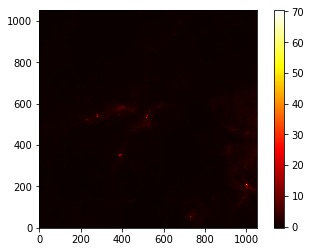

In [12]:
plt.imshow(image_data, cmap = 'hot', origin ='lower')
plt.colorbar()
plt.show()

In [8]:
trimmed_image = image_data - np.min(image_data)
trimmed_image = trimmed_image/np.max(trimmed_image)

trimmed_image[np.where(trimmed_image == 0)] = np.sort(trimmed_image.flatten()[np.where(trimmed_image.flatten()!=0)])[0]/2
print(np.min(trimmed_image))

1.9772412817485704e-05


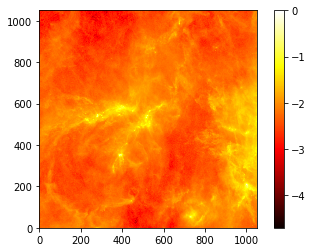

In [11]:
plt.imshow(np.log10(trimmed_image), cmap = 'hot', origin ='lower')
plt.colorbar()
plt.show()

In [19]:
image = np.log10(trimmed_image)
size = image.shape[0]
IMG_SIZE = 128

H_array = np.zeros((size - IMG_SIZE + 1,size - IMG_SIZE + 1))
sigma_array = np.zeros((size - IMG_SIZE + 1,size - IMG_SIZE + 1))

X=[]

for x in range(0,size - IMG_SIZE + 1):
    for y in range(0,size - IMG_SIZE + 1):
        cropped_image = image[y:y+128,x:x+128]
        m_1_field = np.mean(cropped_image)
        s_1_field = np.std(cropped_image)
        m_2_field = 0
        s_2_field = 1/4

        cropped_image = cropped_image*s_2_field/s_1_field
        cropped_image = cropped_image+(m_2_field-m_1_field*s_2_field/s_1_field)
        
        cropped_image[np.where(cropped_image>1.)] = 1.
        cropped_image[np.where(cropped_image<-1.)] = -1.
        
        X = np.array(cropped_image).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
        
        plt.figure()
        plt.imshow(cropped_image, origin = 'lower', cmap = 'hot')
        

        prediction = model.predict(X)
        H = prediction[0][0]
        sigma = prediction[1][0]

        H_array[x,y]=H
        sigma_array[x,y]=sigma
        break
    break
        

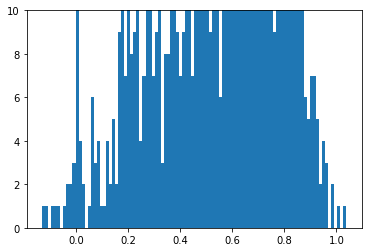

In [21]:
plt.hist(H_array.flatten(),bins=100)
plt.ylim(0,10)
plt.show()